In [57]:
"""
author: Vetivert? 💐 
created: 16/04/2025 @ 16:07:49
"""

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix,\
     make_scorer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from scipy.stats import randint, uniform

import xgboost as xgb
from xgboost import XGBClassifier

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.functions import *


In [3]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


In [61]:
# strategy 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)
df_set = df.loc[222:, :'Oliguria'].copy().fillna(0)

df_alt_ast = df.loc[222:, 'Glu1':'GGT9'].copy()
# print(df_alt_ast['AST1'])
alt_df = pd.DataFrame()
ast_df = pd.DataFrame()
for i in range(9):
    col_1 = 'ALT' + str(i+1)
    alt_df[col_1] = df_alt_ast[col_1]

    col_2 = 'AST' + str(i+1)
    ast_df[col_2] = df_alt_ast[col_2]
# print(ast_df)

alt_df = alt_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
ast_df = ast_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
# print(alt_df)
alt_df[0] = alt_df[0].str.replace(',', '.').astype(float)
alt_df[0].fillna(alt_df[0].mean(), inplace=True)

ast_df[0] = ast_df[0].str.replace(',', '.').astype(float)
ast_df[0].fillna(ast_df[0].mean(), inplace=True)

df_plt = df.loc[222:, 'WBC1':'MPV 9'].copy()
df_plt = df_plt.apply(lambda x: pd.Series(x.dropna().values), axis=1)
for i in range(8):
    df_plt[i] = df_plt[i].str.replace(',', '.')
    df_plt[i] = pd.to_numeric(df_plt[i], errors='coerce')
    df_plt[i].fillna(df_plt[i].mean(), inplace=True)

# df_plt[6] = df_plt[6].str.replace('`', '').replace(',', '.')
# df_plt[6] = pd.to_numeric(df_plt[6], errors='coerce')
# df_plt[7] = df_plt[7].str.replace(',', '.')
# df_plt[7] = pd.to_numeric(df_plt[7], errors='coerce')
# print(df_plt.iloc[:,0:4])
# print(df_plt.isnull().sum())
# print(df_plt[7])

df_set['AST1'] = ast_df[0].astype(float)   # -> -0.02 ACC
df_set['ALT1'] = alt_df[0].astype(float) # -> -0.05 ACC
# df_set['WBC1'] = df_plt[0].astype(float) 
# df_set['N1'] = df_plt[1].astype(float) 
# df_set['L1'] = df_plt[2].astype(float) 
# df_set['RBC1'] = df_plt[3].astype(float)
# df_set['Hb1'] = df_plt[4].astype(float)
# df_set['HCT1'] = df_plt[5].astype(float)
# df_set['PLT1'] = df_plt[6].astype(float) # -> +0.03 ACC
# df_set['MPV1'] = df_plt[7].astype(float) # -> +0.02 ACC 

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set.drop(columns=['Diagnosis']), df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

# rf_1 = RandomForestClassifier(n_estimators=100, random_state=17)
# rf_1.fit(x1_train, y1_train)

# y1_pred = rf_1.predict(x1_test)
# accuracy = accuracy_score(y1_test, y1_pred)
# print(f"Accuracy: {accuracy:.2f}")

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y1_test, y1_pred))

# uniques, counts = np.unique(y1_pred, return_counts=True)
# print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# # Plotting feature importances
# importances = rf_1.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(12, 8))
# plt.title("Feature importances")
# plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(x1_train.shape[1]), features[indices], rotation=90)
# plt.xlim([-1, x1_train.shape[1]])
# plt.axhline(y=importances.mean(), color='r', linestyle='--')
# plt.show()

x1_train shape:  (147, 26) y1_train shape:  (147,)
x1_test shape:  (37, 26) y1_test shape:  (37,)
percentage of classes:  {'1': 45.95, '2': 54.05}


In [ ]:

# Define parameter distributions
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=17),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

# Fit the random search
random_search.fit(x1_train, y1_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.7s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8d660>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8e380>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8e560>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f863de8ea70>},
                   random_state=17,
                   scoring=make_scorer(roc_auc_score, response_method='predict'),
                   verbose=2)

Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.76      0.68        17
           2       0.75      0.60      0.67        20

    accuracy                           0.68        37
   macro avg       0.68      0.68      0.68        37
weighted avg       0.69      0.68      0.67        37

percentage of predictions:  {'1': 56.76, '2': 43.24}


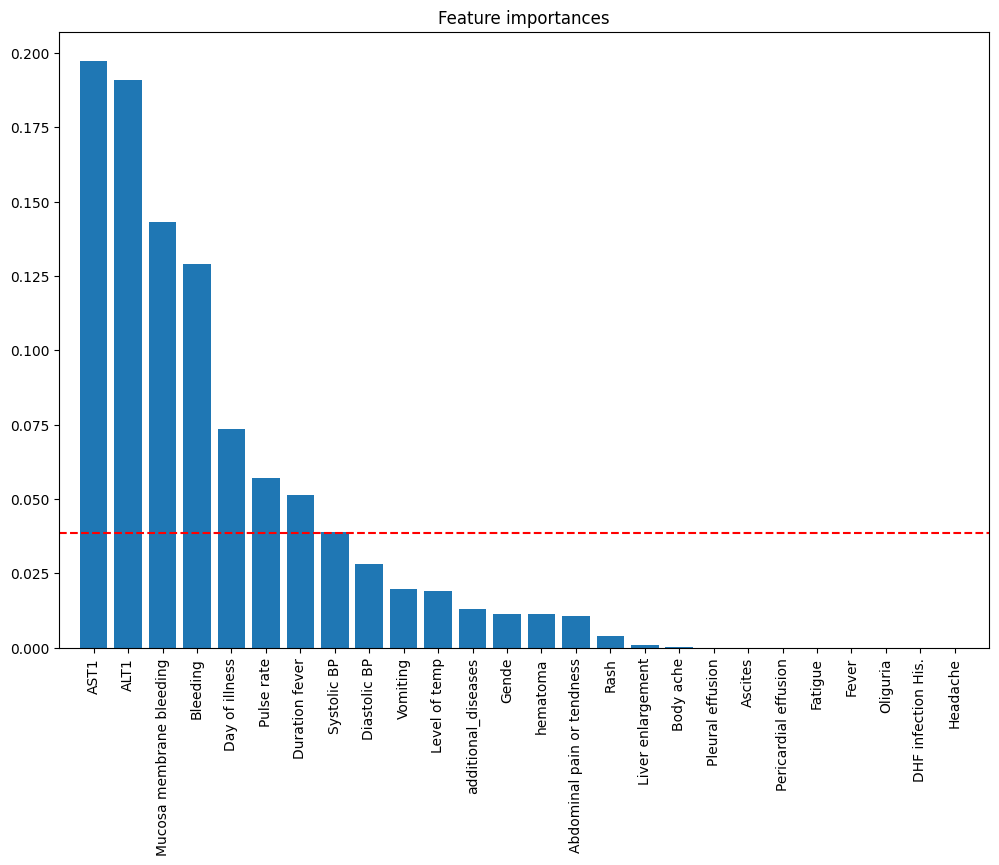

In [ ]:
# rf_1 = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=3,
#                        n_estimators=347, random_state=17) # acc: 70, 1_f1: 73, 2_f1: 67
# rf_1 = RandomForestClassifier(max_depth=19, min_samples_leaf=8, min_samples_split=23,
#                        n_estimators=491, random_state=17) # RBC+WBC, acc: 73, 1_f1: 74, 2_f1: 72
# rf_1 = RandomForestClassifier(max_depth=34, max_features='log2', min_samples_leaf=8,
#                        min_samples_split=10, n_estimators=71, random_state=17) # PLT+MPV, acc: 73, 1_f1: 74, 2_f1: 72
rf_1 = RandomForestClassifier(max_depth=38, max_features='log2', min_samples_leaf=5,
                       min_samples_split=3, n_estimators=374, random_state=17) # ALT+AST, acc: 68, 1_f1: 68, 2_f1: 67
rf_1.fit(x1_train, y1_train)

y1_pred = rf_1.predict(x1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))

uniques, counts = np.unique(y1_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# Plotting feature importances
importances = rf_1.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x1_train.shape[1]), x1_features[indices], rotation=90)
plt.xlim([-1, x1_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [ ]:
alt_ast = df.loc[:, 'Glu1':'GGT9'].copy().fillna(0)
alt_ast = alt_ast.drop(['Bil TP7', 'Bil TT 7'], axis=1)

plt_df = df.loc[:, 'WBC1':'MPV 9'].copy().fillna(0)
# print(alt_ast.shape)

alt_ast = alt_ast.apply(pd.to_numeric, errors='coerce')
plt_df = plt_df.apply(pd.to_numeric, errors='coerce')

# for i in range(plt.shape[0]):
#     plt[i] = plt[i].str.replace(',', '.')
#     plt[i] = pd.to_numeric(plt[i], errors='coerce')
    
XA_train, XA_test, YA_train, YA_test = train_test_split(alt_ast, df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
alt_ast_features = XA_train.columns

XP_train, XP_test, YP_train, YP_test = train_test_split(plt_df, df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
plt_features = XP_train.columns

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=17),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

# Fit the random search
# random_search.fit(XA_train, YA_train)
random_search.fit(XP_train, YP_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   0.9s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8685c6b550>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8685c6bdc0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8690d89b10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f86903e8c40>},
                   random_state=17,
                   scoring=make_scorer(roc_auc_score, response_method='predict'),
                   verbose=2)

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.71      0.65        17
           2       0.71      0.60      0.65        20

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.66      0.65      0.65        37

percentage of predictions:  {'1': 54.05, '2': 45.95}


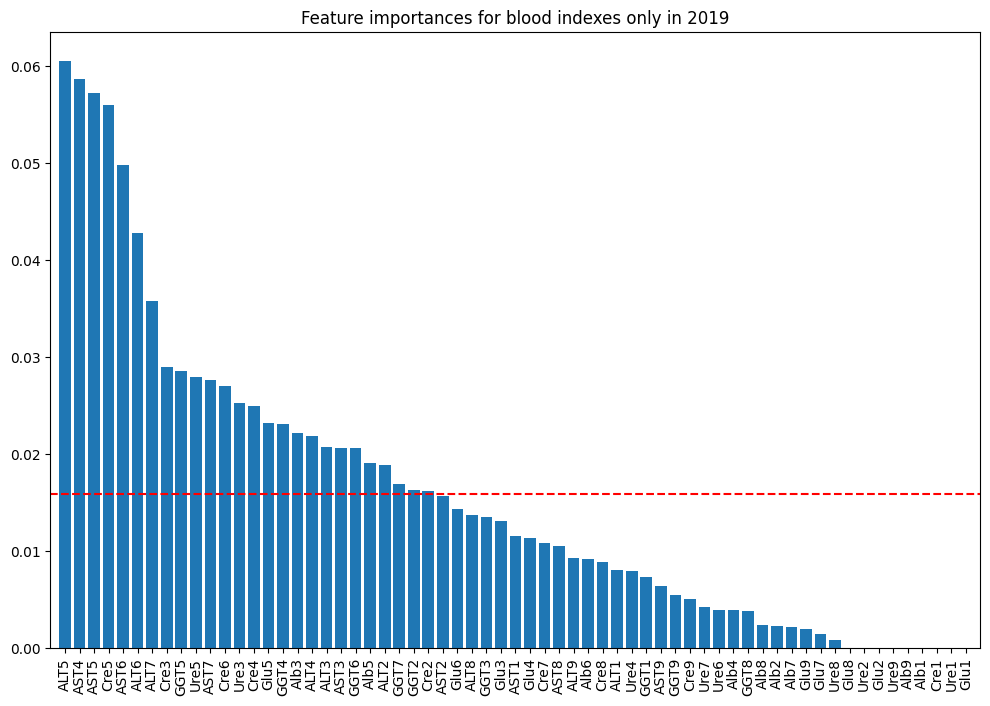

In [50]:
rf_altast = RandomForestClassifier(max_depth=25, max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_estimators=348, random_state=17)
rf_altast.fit(XA_train, YA_train)

YA_pred = rf_altast.predict(XA_test)
accuracy = accuracy_score(YA_test, YA_pred)
print(f"Accuracy: {accuracy:.2f}")
features = XA_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(YA_test, YA_pred))

uniques, counts = np.unique(YA_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YA_pred), 2))))

# Plotting feature importances
importances = rf_altast.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for blood indexes only in 2019")
plt.bar(range(XA_train.shape[1]), importances[indices], align="center")
plt.xticks(range(XA_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, XA_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.71      0.69        17
           2       0.74      0.70      0.72        20

    accuracy                           0.70        37
   macro avg       0.70      0.70      0.70        37
weighted avg       0.70      0.70      0.70        37

percentage of predictions:  {'1': 48.65, '2': 51.35}


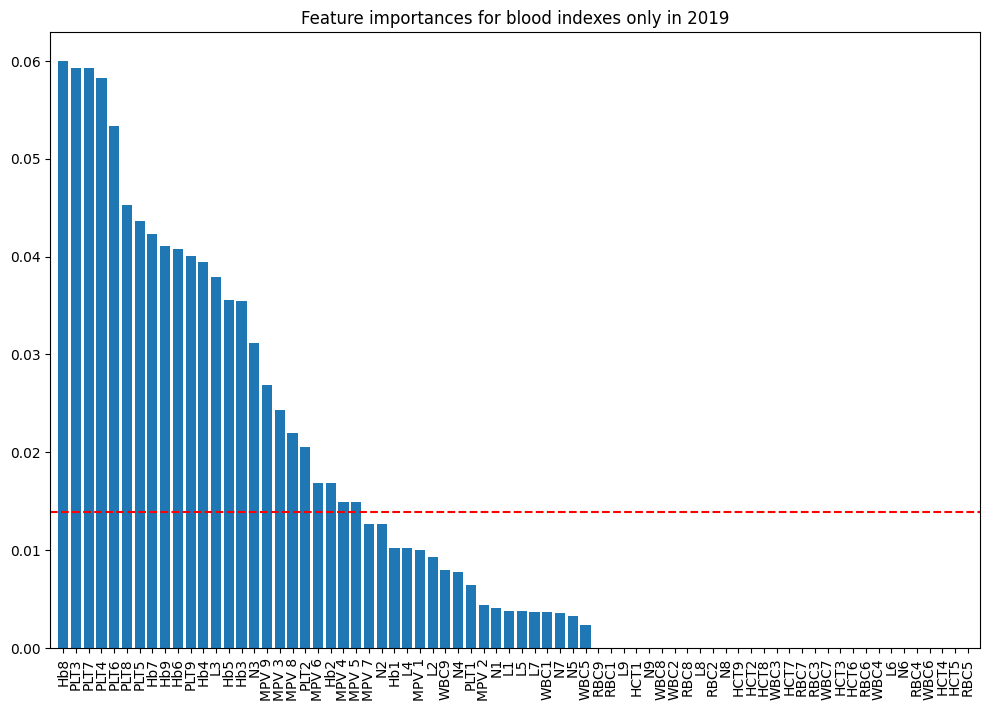

In [56]:
rf_PLT = RandomForestClassifier(max_depth=44, max_features='log2', min_samples_leaf=3,
                       min_samples_split=16, n_estimators=455, random_state=17)
rf_PLT.fit(XP_train, YP_train)

YP_pred = rf_PLT.predict(XP_test)
accuracy = accuracy_score(YP_test, YP_pred)
print(f"Accuracy: {accuracy:.2f}")
features = XP_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(YP_test, YP_pred))


uniques, counts = np.unique(YP_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YP_pred), 2))))

# Plotting feature importances
importances = rf_PLT.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title(f"Feature importances for blood indexes only in 2019")
plt.bar(range(XP_train.shape[1]), importances[indices], align="center")
plt.xticks(range(XP_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, XP_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

## XGBOOST

In [74]:
xgb_1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.1,
                      max_depth=5,
                      use_label_encoder=False,
                      eval_metric='logloss')
# x1_train = x1_train.to_numpy()
# y1_train = y1_train.to_numpy()
# x1_test = x1_test.to_numpy()
# y1_test = y1_test.to_numpy()

for i in range(len(y1_train)):
    if y1_train[i] == '1':
        y1_train[i] = 0
    elif y1_train[i] == '2':
        y1_train[i] = 1  

for i in range(len(y1_test)):
    if y1_test[i] == '1':
        y1_test[i] = 0
    elif y1_test[i] == '2':
        y1_test[i] = 1  
               
xgb_1.fit(x1_train, y1_train)

y1_pred_proba = xgb_1.predict(x1_test)
y1_pred = [1 if p >= 0.5 else 0 for p in y1_pred_proba]
y1_test = [1 if p >= 0.5 else 0 for p in y1_test]
# print(y1_pred)
# print(y1_test)
# Accuracy
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))

# Confusion matrix
cm = confusion_matrix(y1_test, y1_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC
roc_auc = roc_auc_score(y1_test, y1_pred_proba)
print(f"\nROC AUC: {roc_auc:.4f}")


# xgb.plot_importance(xgb_1, importance_type='gain', max_num_features=10)
# plt.title('Top 10 Feature Importances (by Gain)')
# plt.show()

/home/smivys/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:50:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7297

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.81      0.65      0.72        20

    accuracy                           0.73        37
   macro avg       0.74      0.74      0.73        37
weighted avg       0.75      0.73      0.73        37


Confusion Matrix:
[[14  3]
 [ 7 13]]

ROC AUC: 0.7368


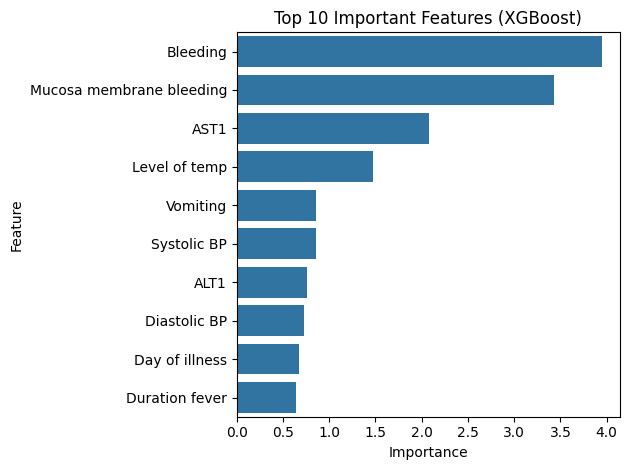

In [72]:
importances = xgb_1.get_booster().get_score(importance_type='gain')

mapped_importances = {x1_features[int(k[1:])]: v for k, v in importances.items()}

mapped_importances_df = pd.DataFrame({
    'Feature': list(mapped_importances.keys()),
    'Importance': list(mapped_importances.values())
}).sort_values(by='Importance', ascending=False)


sns.barplot(x='Importance', y='Feature', data=mapped_importances_df.head(10))
plt.title("Top 10 Important Features (XGBoost)")
plt.tight_layout()
plt.show()

# print(mapped_importances)
# print(importances)

               precision    recall  f1-score   support
non dangerous   0.666667  0.823529  0.736842  17.00000
dangerous       0.812500  0.650000  0.722222  20.00000
accuracy        0.729730  0.729730  0.729730   0.72973
macro avg       0.739583  0.736765  0.729532  37.00000
weighted avg    0.745495  0.729730  0.728939  37.00000


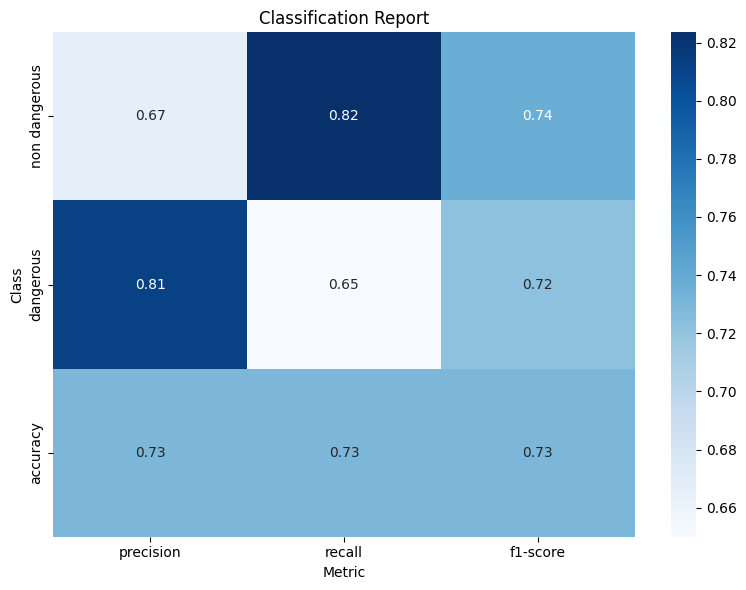

In [ ]:
report_dict = classification_report(y1_test, y1_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.rename(index={'0': 'non dangerous', '1': 'dangerous'}, inplace=True)
# Optional: drop the summary rows
# df_plot = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:3, :3], annot=True, cmap='Blues', fmt=".2f")  # Only show precision, recall, f1-score
plt.title('Classification Report')
plt.ylabel('Class')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()